<a href="https://colab.research.google.com/github/vaibhavmishra1/Deep_Learning_with_Keras/blob/master/Deep_Dream_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications import inception_v3
from keras import backend as K
K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights='imagenet',include_top=False)

Using TensorFlow backend.
W0811 23:54:03.219495 139687729137536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 23:54:03.231587 139687729137536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 23:54:03.235143 139687729137536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 23:54:03.267520 139687729137536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0811

87916544/87910968 [==============================] - 2s 0us/step


In [2]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
layer_contributions = {
'mixed2': 0.2,
'mixed3': 3.,
'mixed4': 2.,
'mixed5': 1.5,
}


layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

W0811 23:54:20.277147 139687729137536 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)




In [0]:
def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values
def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print('...Loss value at', i, ':', loss_value)
    x += step * grad_values
  return x

In [0]:
import scipy
from keras.preprocessing import image
def resize_img(img, size):
  img = np.copy(img)
  factors = (1,float(size[0]) / img.shape[1],float(size[1]) / img.shape[2],1)
  return scipy.ndimage.zoom(img, factors, order=1)
def save_img(img, fname):
  pil_img = deprocess_image(np.copy(img))
  scipy.misc.imsave(fname, pil_img)

def preprocess_image(image_path):
  img = image.load_img(image_path)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img

def deprocess_image(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
  else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2.
  x += 0.5
  x *= 255.
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = '/content/rose-blue-flower-rose-blooms-67636.jpeg'
img = preprocess_image(base_image_path)

In [0]:
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

Processing image shape (168, 255)
(1, 331, 500, 3)
...Loss value at 0 : 9.944649
Processing image shape (236, 357)
(1, 168, 255, 3)


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (331, 500)
(1, 236, 357, 3)


W0812 00:35:07.051093 139687729137536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape= (331, 500, 3)


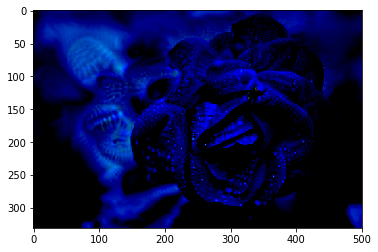

In [47]:
import matplotlib.pyplot as plt
for shape in successive_shapes:
  print('Processing image shape', shape)
  print(img.shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img,
                        iterations=iterations,
                        step=step,
                        max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)
img2=img[0,:,:,:]
print("image shape=",img2.shape)
plt.imshow(img2)